# Histopathologic Cancer Detection
Cancer detection is an important area in the field of biomedical data science. AI-assisted classification of tissues can help physicians detect cancerous tissues, preventing false negatives and speeding up medical diagnostics. Here, we utilize Convolutional Neural Networks (CNNs) to help classify the cancer tissue. We will train and evaluate a number of CNN architectures. Specifically, we will utilize an architecture inspired by LeNet-5. LeNet-5 classically inputs a $32 \times 32$ image through a series of convolutions and average pooling layers. This is followed by a series of dense layers which ultimately classify each sample. This work is done in part of *Kaggle's Histopathologic Cancer Detection* competition.

This work can be found the respective github repository: https://github.com/benjamin-ahlbrecht/histopathologic-caner-detection

A series of approximately $220,000\:$ $96 \times 96$ `.tif` images of tissue are accompanied by labels, where a $0$ corresponds to a label with no cancer and a $1$ corresponds to a label where cancer is detected. Importantly, the labeling decision is made based on whether there exists cancerous tissue in the $32 \times 32$ area in the center of each image. Consequently, we will first crop the images prior to feeding them into the model. This will exponentially reduce the number of trainable parameters, significantly improving training time without sacrificing classification performance. To ensure our first convolutional layer will not lose edge information, we will adding $4$ pixels of padding on either side, resulting in a $36 \times 36$ image.

## Data Downloading
To download the training and testing data, we can utilize the `kaggle` CLI. Python's package manager, `pip`, is used to install this. *If you are running this, you will have to have to authenticate your client by creating and downloading an API token found under your Kaggle account settings*. If you are running this in Google Colab, the second cell allows one to upload their API key to download the competition data.

In [ ]:
%%bash
# Install the Kaggle cli
pip install kaggle

In [22]:
# IF YOU ARE USING GOOGLE COLAB, RUN THIS TO UPLOAD KAGGLE API KEY (kaggle.json)
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
%%bash
%%time
# Download and unzip the kaggle competition into ./data/
mkdir data
cd data

printf "Downloading the HistoPathologic Cancer Detection Dataset\n"
kaggle competitions download -c histopathologic-cancer-detection

printf "Unzipping the Dataset\n"
unzip histopathologic-cancer-detection.zip

In [1]:
%%bash
# Understand the data format and size
cd data

pwd
du --block-size=G

echo ""
ls -la

/home/benjamin/Git/histopathologic-caner-detection/src/data
1G	./train/.ipynb_checkpoints
1G	./train/.comments
6G	./train
2G	./test
14G	.

total 6721684
drwxr-xr-x 4 benjamin benjamin       4096 Sep  1 20:13 .
drwxr-xr-x 5 benjamin benjamin       4096 Sep 19 10:05 ..
-rw-r--r-- 1 benjamin benjamin 6773228425 Sep  1 09:57 histopathologic-cancer-detection.zip
-rw-r--r-- 1 benjamin benjamin   76607678 Sep  1 20:13 Miniconda3-latest-Linux-x86_64.sh
-rw-r--r-- 1 benjamin benjamin    2470703 Dec 12  2019 sample_submission.csv
drwxr-xr-x 2 benjamin benjamin    4329472 Sep  1 09:57 test
drwxr-xr-x 4 benjamin benjamin   16805888 Sep  1 11:11 train
-rw-r--r-- 1 benjamin benjamin    9461084 Dec 12  2019 train_labels.csv


## Data Source and Ingestion 
Here, we perform some necessary preliminary actions: loading packages, obtaining the directory and file paths for the source directory, the data directory, the data training directory, the data testing directory, and the metadata files containing the training labels for each respective training image. The `train_labels.csv` is loaded in as a Pandas dataframe, and we append the full path of the image to the dataframe to streamline data ingestion.

In [2]:
%load_ext autoreload
%autoreload 2

In [25]:
import numpy as np
import pandas as pd
import random
import os

# Image Processing/Loading
from PIL import Image

# Plotting capabilities
from matplotlib import pyplot as plt
import altair as alt

# Multiprocessing
import concurrent.futures
from itertools import repeat

# ML/DL
import tensorflow as tf
from tensorflow import keras

# Hyperparameter Tuning
import keras_tuner as kt

np.set_printoptions(precision=3)

In [4]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  print("Not running on TPU")


Not running on TPU


In [5]:
# Obtain relevant paths
DIR_SRC = os.getcwd()
DIR_DATA = f"{DIR_SRC}/data"
DIR_DATA_TRAIN = f"{DIR_DATA}/train"
DIR_DATA_TEST = f"{DIR_DATA}/test"

# Store the location of our training labels dataset
FILE_METADATA_TRAIN = f"{DIR_DATA}/train_labels.csv"

In [6]:
print(f"""\
Source Directory:     {DIR_SRC}
Data Directory:       {DIR_DATA}
Data Train Directory: {DIR_DATA_TRAIN}
Data Test Directory:  {DIR_DATA_TEST}
Training Labels File: {FILE_METADATA_TRAIN}
""")

Source Directory:     /home/benjamin/Git/histopathologic-caner-detection/src
Data Directory:       /home/benjamin/Git/histopathologic-caner-detection/src/data
Data Train Directory: /home/benjamin/Git/histopathologic-caner-detection/src/data/train
Data Test Directory:  /home/benjamin/Git/histopathologic-caner-detection/src/data/test
Training Labels File: /home/benjamin/Git/histopathologic-caner-detection/src/data/train_labels.csv



In [7]:
# Load in the training labels as a pandas dataframe
METADATA_TRAIN = pd.read_csv(FILE_METADATA_TRAIN)

# Add in the full path to the id, so we can grab it easier
METADATA_TRAIN["path"] = DIR_DATA_TRAIN + "/" + METADATA_TRAIN["id"] + ".tif"

In [8]:
METADATA_TRAIN.head(10)

,id,label,path
0,f38a6374c348f90b587e046aac6079959adf3835,0,/home/benjamin/Git/histopathologic-caner-detec...
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,/home/benjamin/Git/histopathologic-caner-detec...
2,755db6279dae599ebb4d39a9123cce439965282d,0,/home/benjamin/Git/histopathologic-caner-detec...
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,/home/benjamin/Git/histopathologic-caner-detec...
4,068aba587a4950175d04c680d38943fd488d6a9d,0,/home/benjamin/Git/histopathologic-caner-detec...
5,acfe80838488fae3c89bd21ade75be5c34e66be7,0,/home/benjamin/Git/histopathologic-caner-detec...
6,a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da,1,/home/benjamin/Git/histopathologic-caner-detec...
7,7f6ccae485af121e0b6ee733022e226ee6b0c65f,1,/home/benjamin/Git/histopathologic-caner-detec...
8,559e55a64c9ba828f700e948f6886f4cea919261,0,/home/benjamin/Git/histopathologic-caner-detec...
9,8eaaa7a400aa79d36c2440a4aa101cc14256cda4,0,/home/benjamin/Git/histopathologic-caner-detec...


## Exploratory Data Analysis
An exploratory data analysis on images may be difficult to perform. However, there are a few things we can do to ensure that model building will go well: We can display random images alongside their label to gain an intuitive idea of what we are trying to achieve, and we can plot a histogram of the training label frequencies to see how much data we actually have and how balanced our classes are. The Kaggle competition indicates a sample as positive for cancer if there exists cancerous tissue in a $32 \times 32$ pixel region at the center of the image. To emphasize this, we will highlight the area in our visualizations.

In [9]:
def tif_to_numpy(fname):
    """Load a .tif image as a NumPy array given the file name.
    
    Parameters
    ----------
    fname: string
        The input string for the .tif image
    
    Returns
    -------
    image: np.ndarray
        The 3D NumPy array corresponding to the iamge
    """
    # Load the tif as an Image
    image = Image.open(fname)
    return np.array(image)


def extract_sub_square_mask(arr, l):
    """Extracts a sub-square mask from a square NumPy array of size
    (l x l x ...), wherein all values are 0 except the square of length l in
    the center.
    
    Parameters
    ----------
    arr: np.ndarray
        The square NumPy array to sub-square mask.
    l: int
        The desired side-length of the center square to mask
        
    Returns
    -------
    arr_mask: np.ndarray
        The sub-squared and masked NumPy array. All values are False except the
        elements present in the sub-square.
    """
    n = arr.shape[0]
    
    start = n - (l * 2)
    end = n - l
    
    arr_mask = np.full((n, n), False)
    arr_mask[start:end, start:end] = True
    
    return arr_mask


def extract_sub_square(arr, l):
    """Extacts a sub-square from a square NumPy array of size
    (l x l x ...).
    
    Parameters
    ----------
    arr: np.ndarray
        The square NumPy array to subset.
    l: int
        The desired side-length of the center square to extract.
    
    Returns
    -------
    arr_sub: np.ndarray
        The sub-squared array
    """
    n = arr.shape[0]
    
    start = n - (l * 2)
    end = n - l
    
    arr_sub = arr[start:end, start:end]
    return arr_sub
    


def display_random_images(metadata_train, n=3):
    """Display n*n random images as a matplotlib figure from the train_csv dataframe
    
    Parameters
    ----------
    metadata_train: list of strings
        The input metadata
        
    n: int
        The number of images to select for a row. A total of n^2 images will be
        selected.
    """
    n2 = n * n
    indices = random.sample(range(n2), n2)
    
    # Extract the images and their label
    image_labels = [metadata_train["label"][i] for i in indices]
    
    # Load in the images
    images = [tif_to_numpy(metadata_train["path"][i]) for i in indices]
    
    # Display each image in a subplot
    fig, ax = plt.subplots(figsize=(3.5*n, 3.5*n), ncols=n, nrows=n, tight_layout=True)
    
    # Generate a mask to detect the center of the image
    mask = extract_sub_square_mask(images[0], 32)
    print(mask.shape)
    
    # k will serve as a pointer to our image and label
    k = 0
    
    for i in range(n):
        for j in range(n):
            # Plot the individual image in an axis
            image = images[k]
            image[~mask] = image[~mask] * 0.5
            
            # Highlight the center 32 x 32 region
            ax[i, j].axis("off")
            ax[i, j].imshow(image)
            ax[i, j].set_title(f"Label: {image_labels[k]}")
            
            k += 1

(96, 96)


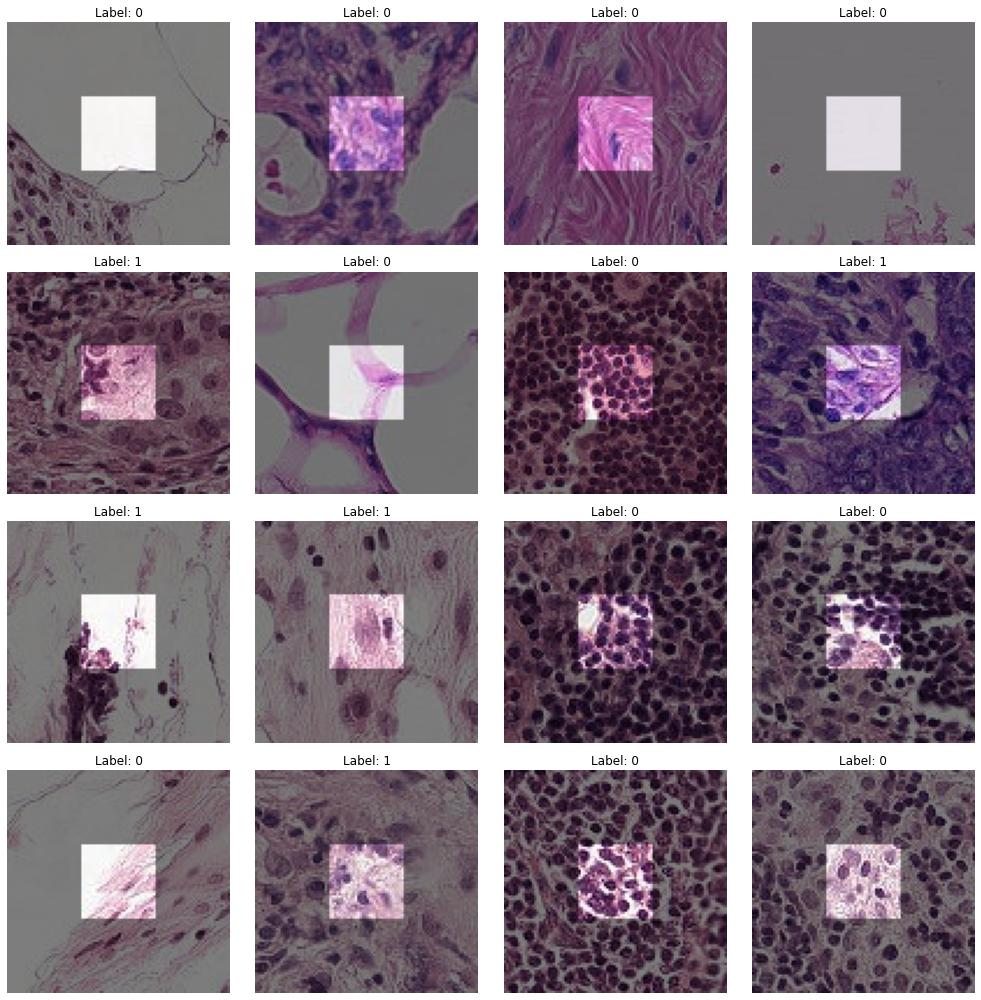

In [10]:
display_random_images(METADATA_TRAIN, n=4)

In [11]:
# Generate a figure to determine the distribution of training labels
source = pd.DataFrame({
    "Label": ["0 (No Cancer)", "1 (Cancer)"],
    "Count": [sum(METADATA_TRAIN["label"] == 0), sum(METADATA_TRAIN["label"] == 1)]
})


(
    alt.Chart(source)
    .mark_bar()
    .encode(
        x=alt.X("Label:O", axis=alt.Axis(labelAngle=0)),
        y=alt.Y("Count:Q")
    )
    .properties(width=500, height=300)
)

alt.Chart(...)

## Data Preprocessing
To preprocess the dataset, we load in each image using `PIL`. These images are converted into NumPy arrays, which are then cropped from $96 \times 96$ to $36 \times 36$. After this, we normalize each image. We use multiprocessing to speed up this computationally intensive image-reading process.

In [17]:
def normalization(image):
    """Normalize an image across each RGB channel using the z-score.
    
    Parameters
    ----------
    image : tf.tensor
        The input image
    
    Returns
    -------
    image_z : tf.tensor
        The z-score normalized image
    """ 
    image_z = image / 255
    
    return image_z


def process_image(path, image_length):
        return normalization(extract_sub_square(tif_to_numpy(path), image_length))

def image_reader(image_paths, image_length=32):
    """Read in a collection of images from given paths, crops them into sub-
    squares, then normalizes them.
    
    Parameters
    ----------
    image_paths: iterable of strings
        The image paths to process
    image_length: int, default=32
        The desired side-lengths of the new images
        
    Returns
    -------
    image_array: iterable of np.ndarrays
        The processed images
    """
    with concurrent.futures.ProcessPoolExecutor(max_workers=None) as executor:
        image_array = executor.map(process_image, image_paths, repeat(image_length)) 

    return list(image_array)

In [18]:
# Create the full dataset of the metadata
IMAGE_PATHS = METADATA_TRAIN["path"]
IMAGE_LABELS = np.array(METADATA_TRAIN["label"]).reshape(-1, 1)
    
# Define how we will split the dataset
train_proportion = 0.75
y_train = np.array(IMAGE_LABELS)
n = len(y_train)


# Labels are assigned based on (32 x 32) square; add some padding for convolutions
padding = 4
image_length = 32 + padding


print(f"""\
Size of Dataset:       {n}
Train Proportion:      {train_proportion}
Validation Proportion: {1 - train_proportion}
Image Padding:         {padding}
Image Size:            {image_length} x {image_length}
""")

Size of Dataset:       220025
Train Proportion:      0.75
Validation Proportion: 0.25
Image Padding:         4
Image Size:            36 x 36



In [16]:
%%time
# Proceess all of our images into NumPy arrays before we make a dataset
x_train = image_reader(IMAGE_PATHS, image_length=image_length)

CPU times: user 1min 10s, sys: 17.4 s, total: 1min 27s
Wall time: 1min 31s


## Model Architecture and Building
Here, we implement the modified LeNet-5 model as discussed above. LeNet-5 is composed of an input layer of size $32 \times 32$. Since our image is $96 \times 96$ and classsification if based on the $32 \times 32$ pixel square in the center, we utilize an input size of $36 \times 36$ to ensure we do not lose any edge information during our convolutions. LeNet-5 follows this through a series of $5 \times 5$ convolutions with a stride of $1 \times 1$. Classically, LeNet-5 utilizes 6 filters in the first convolution and 16 layers in the second convolution. Increasing the number of filters allows us to extract more fine-grained or local information from the image. We will use 12 layers in the second convolution rather than 16 since our image is not greyscale. This will help improve training time. Additionally, we will use the standard ReLU activation function rather than the sigmoid or tanh activation that LeNet-5 would use, which should improve model performance and training time. Inbetween each convolution is an average pooling layer which reduces the dimensionality of the feature maps by $50\%$. After the second average pool, we flatten the feature map before feeding it into a fully-connected ANN. The ANN is composed of 3 layers with a decreasing number of neurons: 120 neurons to 40 neurons to only a single neuron for cancer classsification.

Since this is a binary classification problem, we will utilize binary cross entropy as a loss function. We will use the *Adam gradient descent* for back-propogation, which improves on ordinary gradient descent by keeping track of the error surface's moments to ensure that we move down the surface smoothly. Finally, since the competition is graded based on AUC, we keep track of the AUC. Since the classes are relatively balanced, the accuracy should also be a useful metric. To avoid overfitting, we utilize early stopping and monitor the validation AUC with a patience of 3. This means that if our validation AUC does not improve after 3 epochs, we will stop learning and return the model with the highest validation AUC.

![lenet5](assets/lenet5.png)

In [37]:
def lenet_builder(hp):
    # Define hyper-parameter space
    hp_units_d1 = hp.Choice("units", values=[64, 96, 128])
    hp_units_d2 = hp.Choice("units", values=[32, 64])
    hp_lr = hp.Choice("learning_rate", values=[1e-3, 1e-4, 1e-5])
    
    lenet = keras.Sequential([
        keras.layers.Input((36, 36, 3)),
        keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation="relu"),
        keras.layers.AveragePooling2D(),

        keras.layers.Conv2D(filters=12, kernel_size=(5, 5), activation="relu"),
        keras.layers.AveragePooling2D(),

        keras.layers.Flatten(),

        keras.layers.Dense(units=hp_units_d1, activation="relu"),
        keras.layers.Dense(units=hp_units_d2, activation="relu"),
        keras.layers.Dense(units=1, activation="sigmoid")
    ])
    

    lenet.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_lr),
        loss="binary_crossentropy",
        metrics=["accuracy", "AUC"],
        steps_per_execution=1
    )
    
    return lenet

# Early callbacks for hyperparameter tuning and training
callback = keras.callbacks.EarlyStopping(
    monitor="val_auc",
    patience=3,
    restore_best_weights=True
)

## Hyperparameter Tuning

In [43]:
# Define our hyperparameter tuner
tuner = kt.Hyperband(
    lenet_builder,
    objective="val_loss",
    max_epochs=10,
    factor=3,
)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json


In [ ]:
# Perform the hyperparameter search
tuner.search(
    x_train,
    y_train,
    batch_size=32,
    epochs=20,
    verbose=1,
    validation_split=0.25,
    shuffle=True,
    steps_per_epoch=10,
    workers=8,
    callbacks=[callback]
)

In [51]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the architecture
lenet = tuner.hypermodel.build(best_hps)

IndexError: list index out of range

## Model Training And Validation
Here, we fit the neural network with the training data. A random training and validation split is created each epoch. Selecting random training and validation will help prevent the model from overfitting on the training data. As stated before, we keep track of the AUC and accuracy for the validation and training sets. To examine model performance over time, we plot the metrics over each epoch.

In [52]:
%%time
# Train the architecture
history = lenet.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=20,
    verbose=1,
    callbacks=[callback],
    validation_split=0.25,
    shuffle=True,
    steps_per_epoch=10,
    
)


KeyboardInterrupt



In [ ]:
# Create a dataframe from the training history
source = (
    pd.DataFrame(history.history)
    .reset_index()
    .rename(columns={
        "index": "Epoch",
        "loss": "Loss",
        "accuracy": "Accuracy",
        "auc": "AUC",
        "val_loss": "Validation Loss",
        "val_accuracy": "Validation Accuracy",
        "val_auc": "Validation AUC"
    })
)

source["Epoch"] += 1


# Melt the data for multi-series plotting
source_melt = source.melt(id_vars="Epoch")

display(source)
display(source_melt)

In [ ]:
c1 = (
    alt.Chart(source.melt(["Epoch"], ["Loss", "Validation Loss"]))
    .mark_line(point=alt.OverlayMarkDef())
    .encode(
        x=alt.X("Epoch", type="ordinal"),
        y=alt.Y("value", type="quantitative", title="Loss (Binary Cross Entropy)", scale=alt.Scale(domain=[0, 1])),
        color=alt.Color("variable"),
        strokeDash="variable"
    )
    .properties(
        height=250,
        width=400,
    )
)

c2 = (
    alt.Chart(source.melt(["Epoch"], ["Accuracy", "Validation Accuracy"]))
    .mark_line(point=alt.OverlayMarkDef())
    .encode(
        x=alt.X("Epoch", type="ordinal"),
        y=alt.Y("value", type="quantitative", title="Accuracy", scale=alt.Scale(domain=[0, 1])),
        color=alt.Color("variable"),
        strokeDash="variable"
    )
    .properties(
        height=250,
        width=400,
    )
)

c3 = (
    alt.Chart(source.melt(["Epoch"], ["AUC", "Validation AUC"]))
    .mark_line(point=alt.OverlayMarkDef())
    .encode(
        x=alt.X("Epoch", type="ordinal"),
        y=alt.Y("value", type="quantitative", title="AUC (Area Under Curve)", scale=alt.Scale(domain=[0, 1])),
        color=alt.Color("variable"),
        strokeDash="variable"
    )
    .properties(
        height=250,
        width=400,
    )
)


c4 = (
    alt.hconcat(c1, c2, c3)
    .resolve_scale(color="independent", strokeDash="independent")
    .configure_view(stroke=None)
)

display(c4)

## Model Testing and Evaluation
To evaluate